In [471]:
import collections
import scipy.sparse as sp_sparse
import tables
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
import skimage.external.tifffile
from PIL import Image
import random
import utils
import shutil
import os
import umap
import seaborn as sns
import hdbscan
import scipy as sp
import h5py

np.set_printoptions(suppress=True)

Much taken from:

http://cf.10xgenomics.com/supp/cell-exp/notebook_tutorial-3.0.0.html

# Load data

In [472]:
np.random.seed(0)

FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['feature_ids', 'feature_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename):
    with h5py.File(filename) as f:
        if u'version' in f.attrs:
            if f.attrs['version'] > 2:
                raise ValueError('Matrix HDF5 file format version (%d) is an newer version that is not supported by this function.' % version)
        else:
            raise ValueError('Matrix HDF5 file format version (%d) is an older version that is not supported by this function.' % version)
        
        feature_ids = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['id']]
        feature_names = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['name']]        
        barcodes = list(f['matrix']['barcodes'][:])
        matrix = sp_sparse.csc_matrix((f['matrix']['data'], f['matrix']['indices'], f['matrix']['indptr']), shape=f['matrix']['shape'])
        return FeatureBCMatrix(feature_ids, feature_names, barcodes, matrix)

def get_expression(fbm, gene_name):
    try:
        gene_index = feature_bc_matrix.feature_names.index(gene_name)
    except ValueError:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return fbm.matrix[gene_index, :].toarray().squeeze()

In [473]:
filtered_matrix_h5='/n/core/micro/mg2/rz1989/smc/SequencingAnalysis/filtered_feature_bc_matrix.h5'
feature_bc_matrix = get_matrix_from_h5(filtered_matrix_h5)

/scratch/smc/anaconda3/envs/tflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


Scarlett is nv2m00017230 

nv7R is nv2m00011712 

In [474]:
mScarlet='nv2m00017230.1'
nv7R='nv2m00011712.1'

Plot some simple information

In [475]:
# calculate UMIs and genes per cell
umis_per_cell = np.asarray(feature_bc_matrix.matrix.sum(axis=0)).squeeze()
genes_per_cell = np.asarray((feature_bc_matrix.matrix > 0).sum(axis=0)).squeeze()

data=feature_bc_matrix.matrix.toarray()
data=np.swapaxes(data, 0,1)

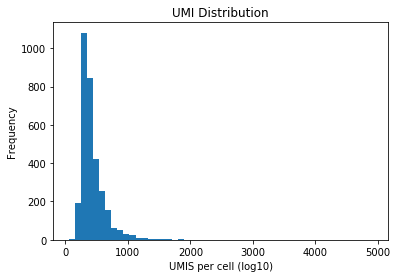

In [476]:
plt.hist((genes_per_cell), bins=50)
plt.xlabel('UMIS per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

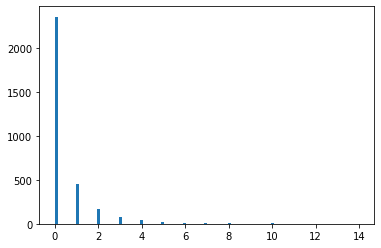

In [477]:
tmp=plt.hist(data[:,feature_bc_matrix[0].index('nv2m00011712.1')], bins=100)

Normalize each cell to have a unity sum of transcripts.

In [478]:
normed_data=data/np.matmul(data.sum(axis=1).reshape([data.shape[0],1]), np.ones([1,data.shape[1]]))

Now apply a filter so that only genes that have some variability are clustered on

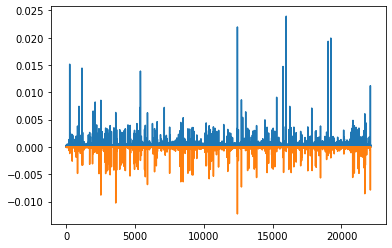

In [479]:
xrng=range(0,normed_data.shape[1])
sd=np.std(normed_data, axis=0)
mn=np.mean(normed_data, axis=0)
plt.plot(xrng, sd, xrng, 0-mean)

In [480]:
#mask=(sd>0.0005)&(sd/mean>0.5)
mask=(sd>0.0001)&(sd/mean>0.5)
np.sum(mask)

/scratch/smc/anaconda3/envs/tflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/scratch/smc/anaconda3/envs/tflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


10505

In [481]:
filtered_data=normed_data[:,mask]
genes=filtered_data.shape[1]

# Initial UMAP

In [482]:
reducer=umap.UMAP(n_neighbors=200,min_dist=0.0,n_components=2)
#reducer=umap.UMAP()
embedding = reducer.fit_transform(filtered_data)
embedding.shape

(3159, 2)

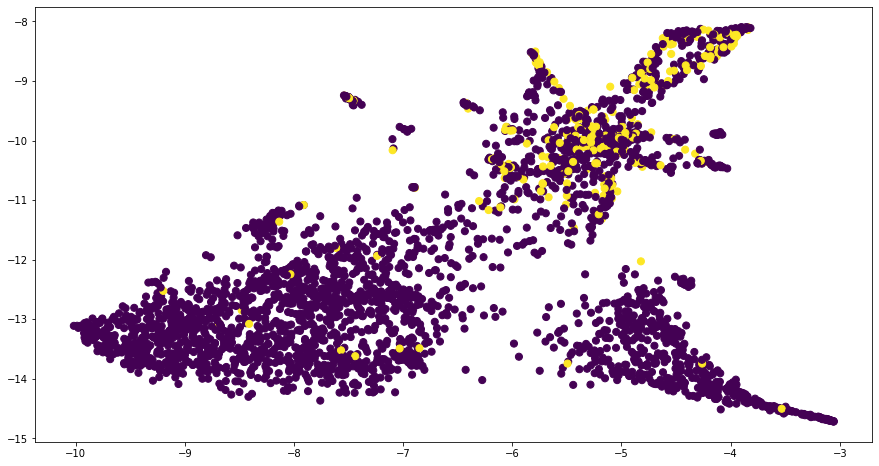

In [483]:
umap_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=40,
).fit_predict(embedding)
plt.figure(figsize=[15,8])
#plt.scatter(embedding[:,0], embedding[:,1], c=[1+x for x in umap_labels], s=3)
plt.scatter(embedding[:,0], embedding[:,1], c=2*(data[:,feature_bc_matrix[0].index(mScarlet)])>0, s=50)

# Neural Network approach

In [484]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, genes])
y=tf.placeholder(dtype=tf.float32, shape=[None, genes])

xr=x
yr=y
lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')

A1=tf.keras.layers.Dense(256, activation=utils.leaky_relu)(xr)
A2=tf.keras.layers.Dense(128, activation=utils.leaky_relu)(A1)
A3=tf.keras.layers.Dense(64, activation=utils.leaky_relu)(A2)
A4=tf.keras.layers.Dense(32, activation=utils.leaky_relu)(A3)
A5=tf.keras.layers.Dense(32, activation=utils.leaky_relu)(A4)
A6=tf.keras.layers.Dense(32, activation=utils.leaky_relu)(A5)

representation=tf.keras.layers.Dense(32, activation=utils.leaky_relu)(A6)
reps=tf.nn.softmax(representation)

B7=tf.keras.layers.Dense(32, activation=utils.leaky_relu)(representation)
B6=tf.keras.layers.Dense(32, activation=utils.leaky_relu)(B7)
B5=tf.keras.layers.Dense(32, activation=utils.leaky_relu)(B6)
B4=tf.keras.layers.Dense(64, activation=utils.leaky_relu)(B5)
B3=tf.keras.layers.Dense(128, activation=utils.leaky_relu)(B4)
B2=tf.keras.layers.Dense(256, activation=utils.leaky_relu)(B3)
rslt=tf.keras.layers.Dense(genes, activation=utils.leaky_relu)(B2)

#logits=utils.leaky_relu(tf.contrib.layers.conv2d(AA3, 2, [1,1], padding='SAME'))
#probs=tf.tanh(logits)

diff=tf.subtract(rslt, yr)
LSQ=tf.multiply(diff,diff)
loss=tf.reduce_mean(LSQ)

maxT=tf.math.reduce_max(representation, axis=1)
sumT=tf.math.reduce_sum(representation, axis=1)
#regular=tf.reduce_sum(tf.math.divide(sumT,maxT ))
reps2=tf.multiply(reps, reps)
diff2=tf.math.reciprocal(reps2)
regular=tf.reduce_mean(diff2)

loss=loss+0.00000000*regular
print(maxT.get_shape())

train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


(?,)


In [487]:
shutil.rmtree('./logs/')
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=50)
test_writer = tf.summary.FileWriter('./logs/170/test')
current_best=[0,1000000000]
xrng=np.arange(0,genes)

learning_rates=[0.000195, 0.0001, 0.00002, 0.00001]
learning_rate_steps=[500,2500, 3200, 60000]
current_step=0
for lrate, lrs in zip(learning_rates, learning_rate_steps):
    for i in range(current_step, lrs):
        idx=np.random.choice(filtered_data.shape[0], replace=False, size=[200])
        cur_train=filtered_data[idx,:]
        cur_truth=filtered_data[idx,:]
        _, results, losses=sess.run([train_op,  rslt, loss], feed_dict={x:cur_train, y:cur_truth, lr:lrate})
        #train_writer.add_summary(summary, i)
        if (i%1000==0):
            print(i)
            print("Training loss: ",losses)
            #idx=np.random.choice(validation_data.shape[0], replace=False, size=[50])
            idx=range(0,20, 1)
            sub_validation_data=filtered_data[idx, :]
            sub_validation_truth=filtered_data[idx, :]
            results, losses=sess.run([rslt, loss], feed_dict={x:sub_validation_data, y:sub_validation_truth})
            print(results.shape)
            print("Validation loss: ",losses)
            #for ti in range (0,3):
            #    plt.figure(figsize=[8,5])
            #    plt.plot(xrng, results[ti,:], xrng, sub_validation_truth[ti,:])
            #    plt.show()
            #saver.save(sess, data+'NewModels/Model'+str(i))
    current_step=lrs

0
Training loss:  8.5798916e-07
(20, 10505)
Validation loss:  4.4926335e-07
1000
Training loss:  7.947341e-07
(20, 10505)
Validation loss:  3.1937904e-07
2000
Training loss:  5.2804586e-07
(20, 10505)
Validation loss:  2.936292e-07
3000
Training loss:  5.193202e-07
(20, 10505)
Validation loss:  2.8721416e-07
4000
Training loss:  4.342473e-07
(20, 10505)
Validation loss:  2.6855386e-07
5000
Training loss:  2.9851674e-07
(20, 10505)
Validation loss:  2.6151596e-07
6000
Training loss:  3.8096414e-07
(20, 10505)
Validation loss:  2.6225393e-07
7000
Training loss:  4.1496037e-07
(20, 10505)
Validation loss:  2.610221e-07
8000
Training loss:  2.9154404e-07
(20, 10505)
Validation loss:  2.5360228e-07
9000
Training loss:  4.5425202e-07
(20, 10505)
Validation loss:  2.616451e-07
10000
Training loss:  2.9302103e-07
(20, 10505)
Validation loss:  2.5114912e-07
11000
Training loss:  2.5915438e-07
(20, 10505)
Validation loss:  2.6041212e-07
12000
Training loss:  3.6739394e-07
(20, 10505)
Validation 

KeyboardInterrupt: 

In [488]:
results, rep, repsoft=sess.run([rslt, representation, diff2], feed_dict={x:filtered_data})

(600, 900)

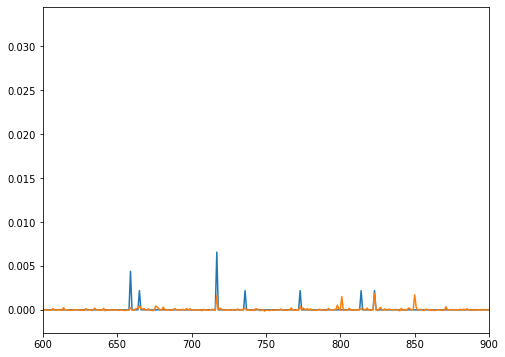

In [489]:
idx=np.random.choice(filtered_data.shape[0], 1)[0]
plt.figure(figsize=[8,6])
plt.plot(range(0,filtered_data.shape[1]), filtered_data[idx,:], range(0,filtered_data.shape[1]), results[idx,:])
plt.xlim(600,900)

UMAP again, this time on the latent space from the neural network.  Also highlight mScarlet positive and nv7R positive cells to find out which cluster are the neurons.

In [490]:
reducer=umap.UMAP(n_neighbors=200,min_dist=0.0,n_components=2)
#reducer=umap.UMAP()
embedding = reducer.fit_transform(rep)
embedding.shape

(3159, 2)

Text(0.5, 1.0, 'nv7R')

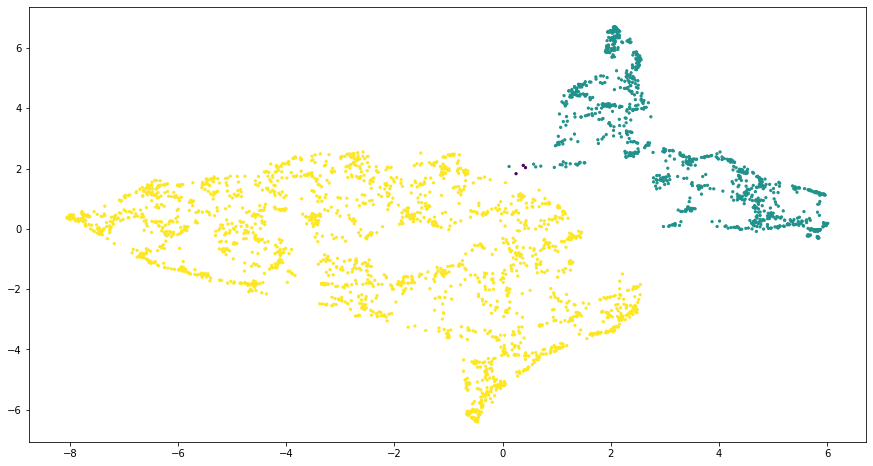

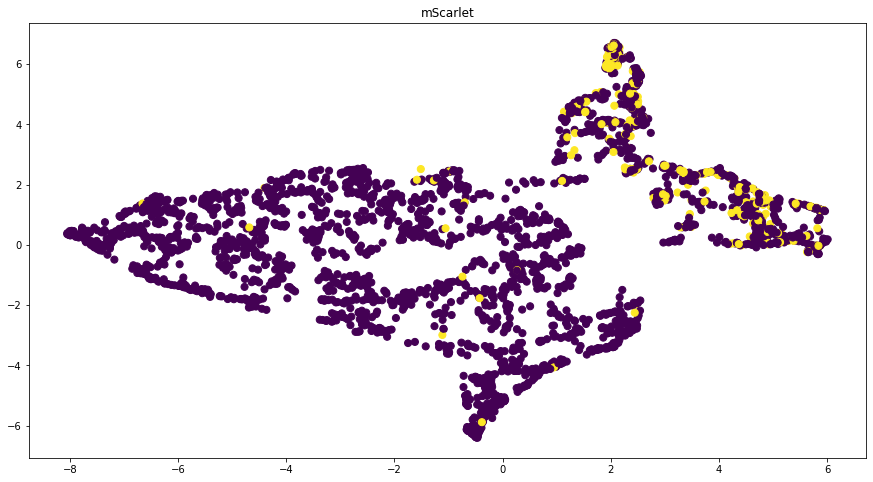

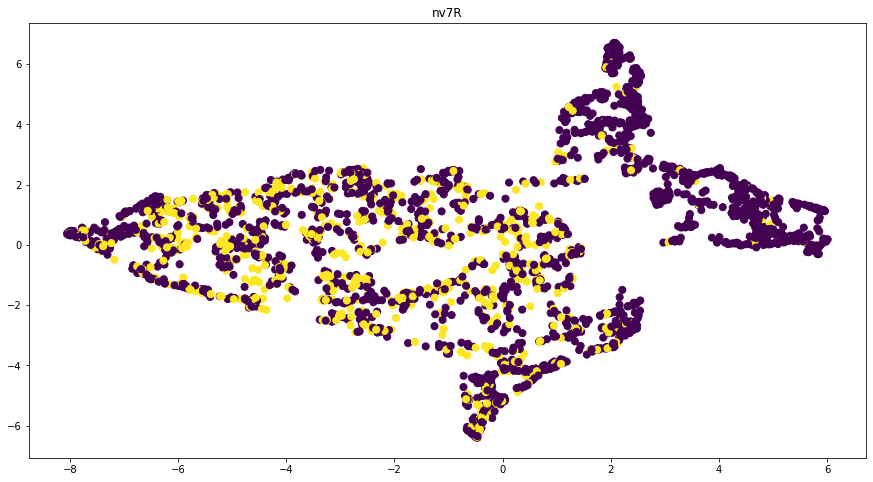

In [493]:
umap_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=200,
).fit_predict(embedding)
plt.figure(figsize=[15,8])
plt.scatter(embedding[:,0], embedding[:,1], c=[x for x in umap_labels], s=5)
plt.figure(figsize=[15,8])
plt.scatter(embedding[:,0], embedding[:,1],c=2*(data[:,feature_bc_matrix[0].index(mScarlet)])>0 , s=50)
plt.title('mScarlet')
plt.figure(figsize=[15,8])
plt.scatter(embedding[:,0], embedding[:,1],c=2*(data[:,feature_bc_matrix[0].index(nv7R)])>0 , s=50)
plt.title('nv7R')

<BarContainer object of 3 artists>

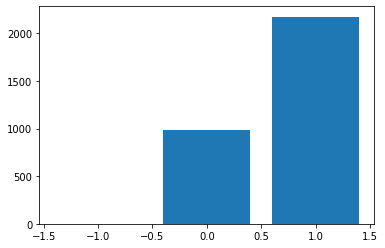

In [494]:
unique, counts=np.unique(umap_labels, return_counts=True)
plt.bar(unique, counts)

Guess which cluster is associated with the mScarlet positive one until you guess right

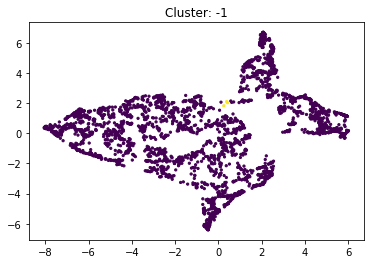

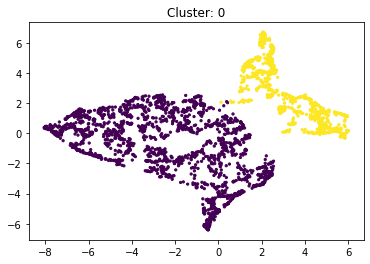

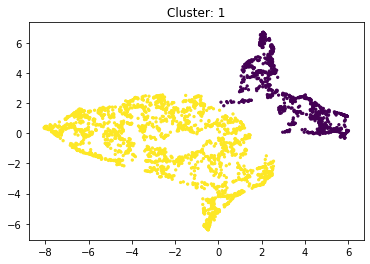

In [496]:
for i in range(-1,np.max(umap_labels)+1):
    #mScarlet_Cluster=4
    plt.figure()
    plt.scatter(embedding[:,0], embedding[:,1], c=umap_labels==i, s=5)
    plt.title('Cluster: '+str(i))

In [497]:
mScarlet_positive=np.isin(umap_labels,[0])
mScarlet_data=filtered_data[mScarlet_positive]

# Repeat for Scarlet positive

In [498]:
reducer=umap.UMAP(n_neighbors=200,min_dist=0.0,n_components=2)
#reducer=umap.UMAP()
embedding = reducer.fit_transform(mScarlet_data)
embedding.shape

(983, 2)

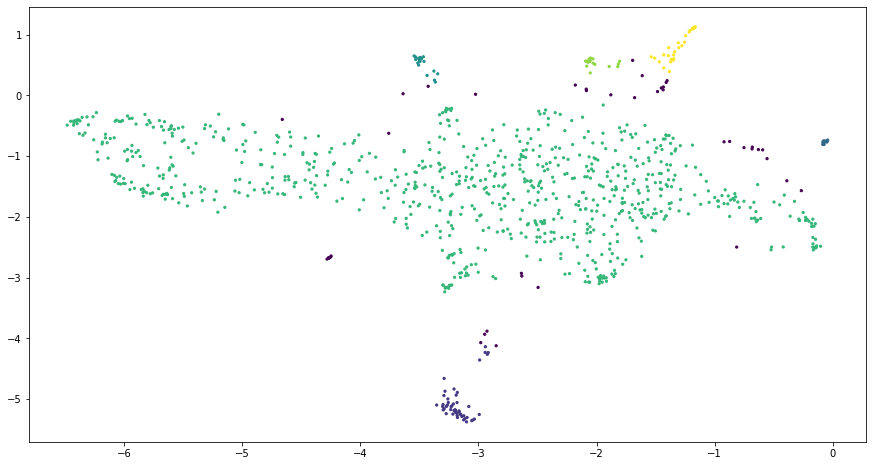

In [499]:
umap_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=10,
).fit_predict(embedding)
plt.figure(figsize=[15,8])
plt.scatter(embedding[:,0], embedding[:,1], c=[x for x in umap_labels], s=5)

In [500]:
shutil.rmtree('./logs/')
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=50)
test_writer = tf.summary.FileWriter('./logs/170/test')
current_best=[0,1000000000]
xrng=np.arange(0,genes)

learning_rates=[0.000195, 0.0001, 0.00002, 0.00001]
learning_rate_steps=[500,2500, 3200, 20000]
current_step=0
for lrate, lrs in zip(learning_rates, learning_rate_steps):
    for i in range(current_step, lrs):
        idx=np.random.choice(mScarlet_data.shape[0], replace=False, size=[200])
        cur_train=mScarlet_data[idx,:]
        cur_truth=mScarlet_data[idx,:]
        _, results, losses=sess.run([train_op,  rslt, loss], feed_dict={x:cur_train, y:cur_truth, lr:lrate})
        #train_writer.add_summary(summary, i)
        if (i%1000==0):
            print(i)
            print("Training loss: ",losses)
            #idx=np.random.choice(validation_data.shape[0], replace=False, size=[50])
            idx=range(0,20, 1)
            sub_validation_data=mScarlet_data[idx, :]
            sub_validation_truth=mScarlet_data[idx, :]
            results, losses=sess.run([rslt, loss], feed_dict={x:sub_validation_data, y:sub_validation_truth})
            print(results.shape)
            print("Validation loss: ",losses)
            #for ti in range (0,3):
                #plt.figure(figsize=[8,5])
                #plt.plot(xrng, results[ti,:], xrng, sub_validation_truth[ti,:])
                #plt.show()
            #saver.save(sess, data+'NewModels/Model'+str(i))
    current_step=lrs

0
Training loss:  7.862809e-07
(20, 10505)
Validation loss:  3.779363e-07
1000
Training loss:  1.0672628e-06
(20, 10505)
Validation loss:  2.8348327e-07
2000
Training loss:  7.0804725e-07
(20, 10505)
Validation loss:  2.77427e-07
3000
Training loss:  6.3044365e-07
(20, 10505)
Validation loss:  2.7927604e-07
4000
Training loss:  6.5043844e-07
(20, 10505)
Validation loss:  2.7364553e-07
5000
Training loss:  7.1779914e-07
(20, 10505)
Validation loss:  2.7231724e-07
6000
Training loss:  5.3658636e-07
(20, 10505)
Validation loss:  2.6360368e-07
7000
Training loss:  4.3145778e-07
(20, 10505)
Validation loss:  2.6494652e-07
8000
Training loss:  4.0579715e-07
(20, 10505)
Validation loss:  2.632142e-07
9000
Training loss:  4.5404943e-07
(20, 10505)
Validation loss:  2.5788256e-07
10000
Training loss:  4.0765246e-07
(20, 10505)
Validation loss:  2.4517954e-07
11000
Training loss:  4.247344e-07
(20, 10505)
Validation loss:  2.4770776e-07
12000
Training loss:  3.4161368e-07
(20, 10505)
Validation 

In [501]:
results, rep, repsoft=sess.run([rslt, representation, diff2], feed_dict={x:mScarlet_data})

(3700, 4400)

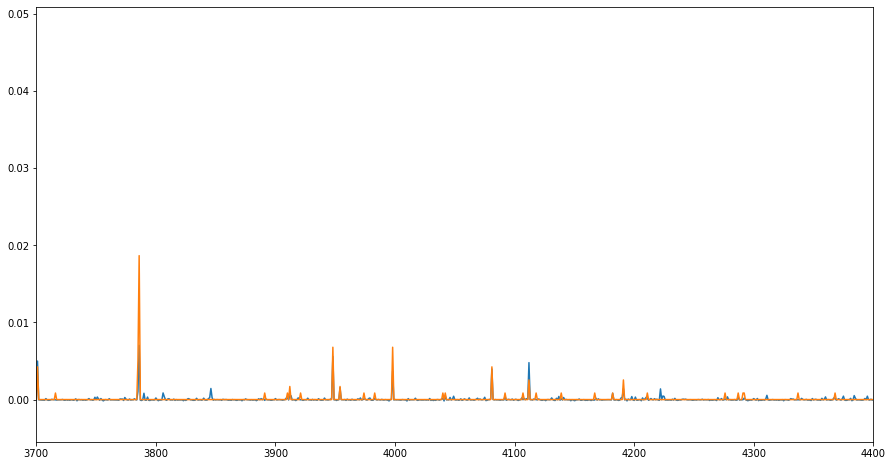

In [502]:
plt.figure(figsize=[15,8])
plt.plot(xrng, results[0,:], xrng, mScarlet_data[0,:])
plt.xlim(3700,4400)

UMAP again, this time on the latent space from the neural network

In [528]:
reducer=umap.UMAP(n_neighbors=2000,min_dist=0.0,n_components=4)
#reducer=umap.UMAP()
embedding = reducer.fit_transform(rep)
embedding.shape

/scratch/smc/anaconda3/envs/tflow/lib/python3.6/site-packages/umap/umap_.py:1383: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(983, 4)

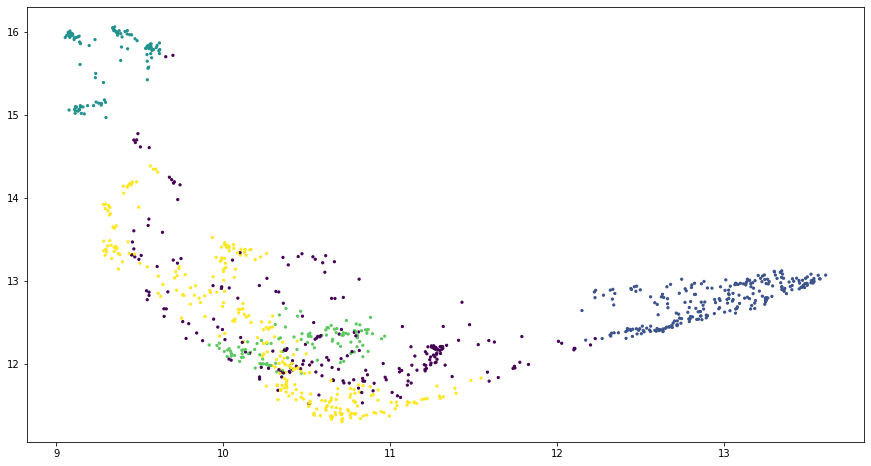

In [535]:
umap_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=80,
).fit_predict(embedding)
plt.figure(figsize=[15,8])
plt.scatter(embedding[:,1], embedding[:,2], c=[x for x in umap_labels], s=5)
#plt.scatter(embedding[:,0], embedding[:,1],c=2*(data[:,feature_bc_matrix[0].index(mScarlet)])>0 , s=50)


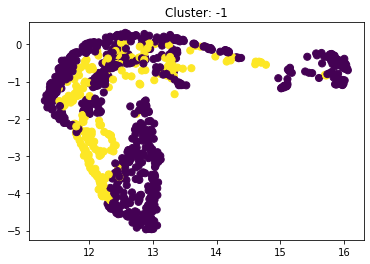

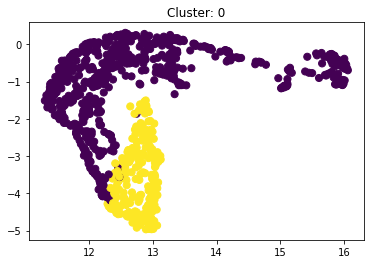

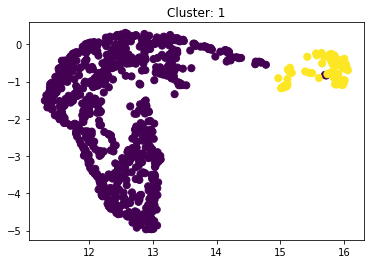

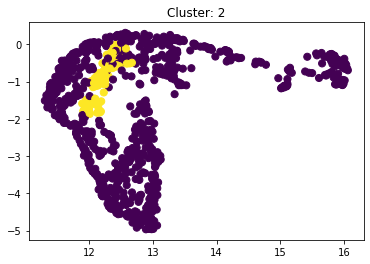

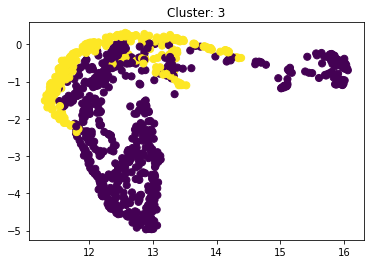

In [541]:
for i in range(-1,np.max(umap_labels)+1):
    #mScarlet_Cluster=4
    plt.figure()
    plt.scatter(embedding[:,1], embedding[:,3], c=umap_labels==i, s=50)
    plt.title('Cluster: '+str(i))

In [543]:
mScarlet_rawdata=data[mScarlet_positive, :]